In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('merged_data1.csv',encoding = 'utf8',sep=';')
X = df[['M_C', 'M_A', 'IS_SYM', 'P', 'T']].values
y = df[['Rho']].values

In [3]:
'''Przygotowanie danych - podzielenie danych na zbiór trenujacy i testowy'''

X_train, X_test, y_train, y_test = train_test_split(
X,y,test_size = 0.4, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print('Test shapes')
print(X_test.shape)
print(y_test.shape)

(1912, 5)
(1912, 1)
Test shapes
(1275, 5)
(1275, 1)


In [4]:
# Skalowanie cech dla lepszej wydajności modelu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
params = {
    'objective': 'reg:squarederror',  # Typ zadania: regresja
    'max_depth': 4,                  # Maksymalna głębokość drzewa
    'learning_rate': 0.1,
    #'num_boost_rounds': 100,# Współczynnik uczeni             # Liczba drzew w modelu
    'random_state': 42               # Ziarno losowości dla reprodukowalności wyników
}

In [8]:
xgb_model = xgb.train(params, dtrain, num_boost_round=300)

In [9]:
y_test_xgb = xgb_model.predict(dtest)
y_train_xgb = xgb_model.predict(dtrain)

In [10]:
### Metryki dla zbioru testowego
r2 = r2_score(y_test, y_test_xgb)
print(f"Współczynnik determinacji R^2: {r2}")
mse = mean_squared_error(y_test, y_test_xgb)
print(f"Błąd średniokwadratowy MSE: {mse}")

Współczynnik determinacji R^2: 0.9989029306452639
Błąd średniokwadratowy MSE: 20.962929387306527


In [11]:
###MEtryki dla zbioru treningowego
r2_train = r2_score(y_train, y_train_xgb)
print(f"Współczynnik determinacji R^2: {r2_train}")
mse_train = mean_squared_error(y_train, y_train_xgb)
print(f"Błąd średniokwadratowy MSE: {mse_train}")

Współczynnik determinacji R^2: 0.9994617860025172
Błąd średniokwadratowy MSE: 10.56367461375687


In [12]:
# Przeprowadź walidację krzyżową z 25 foldami i oblicz R^2 jakość modelu
cv_scores = cross_val_score(xgb.XGBRegressor(**params), X_train, y_train, cv=25, scoring='r2')
# Oblicz średnią wartość R^2 po wszystkich foldach
mean_r2 = cv_scores.mean()
print("Średni R^2 po walidacji krzyżowej:", mean_r2)

Średni R^2 po walidacji krzyżowej: 0.9958101100805241


In [13]:
cv_scores = cross_val_score(xgb.XGBRegressor(**params), X_test, y_test, cv=25, scoring='r2')
# Oblicz średnią wartość R^2 po wszystkich foldach
mean_r2 = cv_scores.mean()
print("Średni R^2 po walidacji krzyżowej:", mean_r2)

Średni R^2 po walidacji krzyżowej: 0.9948277948641484


In [14]:
test_predictions_xgb = pd.Series(y_test_xgb.reshape(1275,))
pred_df = pd.DataFrame(y_test,columns = ['Test TRUE Y'])
pred_df = pd.concat([pred_df,test_predictions_xgb],axis = 1)
pred_df.columns = ['Test true y', 'Pred']

In [15]:
train_predictions_xgb = pd.Series(y_train_xgb.reshape(X_train.shape[0],))
train_df = pd.DataFrame(y_train,columns = ['Test TRUE Y'])
train_df = pd.concat([train_df,train_predictions_xgb],axis = 1)
train_df.columns = ['Test true y', 'Pred']

<Axes: xlabel='Test true y', ylabel='Pred'>

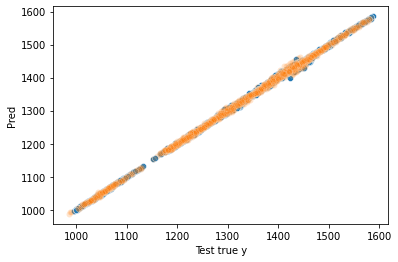

In [16]:
sns.scatterplot(x = 'Test true y', y = 'Pred', data = train_df)
sns.scatterplot(x = 'Test true y', y = 'Pred', data = pred_df, alpha = 0.2)

In [17]:
train_df

,Test true y,Pred
0,1484.17,1484.543457
1,1251.80,1252.745972
2,1414.30,1421.242188
3,1434.54,1455.011475
4,1453.62,1454.238892
...,...,...
1907,1325.50,1333.724121
1908,1023.86,1023.920837
1909,1214.92,1211.991455
1910,1513.35,1511.578979


In [18]:
pred_df

,Test true y,Pred
0,1310.90,1316.249634
1,1266.10,1262.928833
2,1492.27,1492.679688
3,1190.69,1192.402344
4,1061.93,1063.460327
...,...,...
1270,1379.05,1382.843018
1271,1057.40,1056.455566
1272,1421.72,1419.865112
1273,1317.90,1317.821899


In [23]:
import os
directory_path = 'D:/PhD/ML/XBOOST/RHO/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
# train_df.to_csv(os.path.join(directory_path, 'train_set_XB.csv'), sep=';', encoding='utf-8')
# pred_df.to_csv(os.path.join(directory_path, 'test_set_XB.csv'), sep=';', encoding='utf-8') 

In [19]:
def predictions3(MC,MA,SYM,P,T):
    res = []
    for j in T:
        for i in P:
            new_geom = [[MC,MA,SYM,i,j]]
            new_geom = scaler.transform(new_geom)
            new_geom_dmatrix = xgb.DMatrix(new_geom)  # Konwersja na DMatrix
            res.append(xgb_model.predict(new_geom_dmatrix))
            #print(model.predict(new_geom))
    return res

In [38]:
nazwa = 'C4Mim_C1SO4'
Mcat = 139.29
Man = 111.097

P = [0.1,2.5,5,10,15,20,25,30,35]
T = [283.15,285.65,288.15,290.65,293.15,295.65,298.15,300.65,303.15,305.65,308.15,310.65,313.15,315.65,318.15,320.65,323.15,325.65,328.15,330.65,333.15,335.65,338.15,340.65,343.15,345.65,348.15,350.65,353.15]
result = predictions3(Mcat,Man,0,P,T);

In [39]:
res_flat = np.array(result).flatten()  # przekształcenie do jednowymiarowej tablicy numpy
res_numerical = [val.item() for val in res_flat]  # wyodrębnienie wartości liczbowych
# for i in res_numerical:
#     print(i);

In [40]:
directory_path = 'D:/PhD/ML/XBOOST/Rho/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
directory_path + nazwa 
tablica_danych = np.array(res_numerical).reshape(len(T), len(P))
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
dane = pd.DataFrame(tablica_danych)
dane = dane.T
dane.to_excel(directory_path+nazwa+'_Rho_DATA_XB.xlsx', index=False)
raw = pd.DataFrame(res_numerical) ###Zapis wektora danych w postaci kolumny surowych danych
raw.to_excel(directory_path+nazwa+'_Rho_RAW_XB.xlsx', index=False)

In [34]:
try:
    dane.to_excel(os.path.join(directory_path, nazwa+'_Rho_DATA_GB.xlsx'), index=False)
    raw = pd.DataFrame(res_numerical)
    raw.to_excel(os.path.join(directory_path, nazwa+'_Rho_RAW_GB.xlsx'), index=False)
    print("Pliki zostały zapisane poprawnie.")
except Exception as e:
    print("Wystąpił błąd podczas zapisywania plików:", e)

Pliki zostały zapisane poprawnie.
